In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import data_preprocessing as data_prep
from renameFeatures import rename_features, get_data_summary, get_data_summary2
from data_vizualization import metrics_plotting, metrics_plotting_with_events

#### Data renaming and summary collection TOBE

In [2]:
DO_RENAME = False
DO_JOIN = False

In [3]:
PATH = "C:\\Users\\vladv\\predictiveAnalytics\\data\\"

In [4]:
# All wells data is located in 1 to 6 folders
if DO_RENAME:
    for well in range(1, 9):
        print(f"WELL: {well}")
        directory = PATH + str(well)
        rename_features(directory)

#### Data joining

I tried multiple methods from resampling to union, interpolating etc. All of them loose some data dynamics or give too much observations if total. <br>So I've decided to use forward filling (ffill) to pivot table of all the features per well

In [5]:
# I'll use wells that have needed operational regime due to complexness of data
wells_final = [1, 4, 7, 8]
# wells_final = [2, 3, 6]

In [6]:
# All the data needed is located in folders named from 1 to 6
wells_data = []
all_events = data_prep.get_events_summary(PATH)

for well in wells_final:
    print(f"DIRECTORY: {well}")
    directory = PATH + "\\" + str(well)
    if DO_JOIN:
        full_data = data_prep.join_data_v2(directory)
    else:
        file_name = "full_data_events.csv"
        full_data = pd.read_csv(directory+"\\" + file_name)
        if well in [2, 3, 6]:
            full_data = data_prep.join_events_to_data(full_data, all_events)

    full_data["time"] = pd.to_datetime(full_data["time"])
    wells_data.append(full_data)

DIRECTORY: 1
DIRECTORY: 4
DIRECTORY: 7
DIRECTORY: 8


In [7]:
# map_wells_index = {1: 0, 4: 1, 7: 2, 8: 3}
map_wells_index = {1: 0, 2: 1, 3: 2, 4: 3, 6: 4, 7: 5, 8: 6}

In [8]:
well_to_check = 2
test_data = wells_data[map_wells_index[well_to_check]].copy()

Most wells present periods in frequency, operational current, active power and motor load.<br>Also some metrics show outliers, I'll leave it for now

In [9]:
test_data.isna().sum().to_frame().to_clipboard()

In [10]:
test_data[test_data["event_id"] != 0].shape[0]/test_data.shape[0]

0.09657607744351175

Vizualizing events 

In [11]:
# all_events = data_prep.get_events_summary(PATH)
events_needed = all_events[all_events["well_id"] == well_to_check]

In [12]:
wells_data[0].columns.tolist().count("time")

1

In [13]:
# metrics_plotting_with_events(test_data, events_needed)

Now with much higher frequency of data it seems difficult to conclude something, but some observations:

- Looks like event 962 correlates with gas breakthrough, but not everywhere
- Events 965 and 674 might be dependent on power of the pump
- Intake Pressure has high values not leading to any failure referencing to the events data. Measurment error?
- Why does oil rate falls to zero, but liquid rate remains > 0? Futhermore when it appears at the end of 2021 year it's higher than liquid rate???

I decided to code new function "check_oil_rate" to check oil rate values, because now its behavior looks incorrect

<AxesSubplot:>

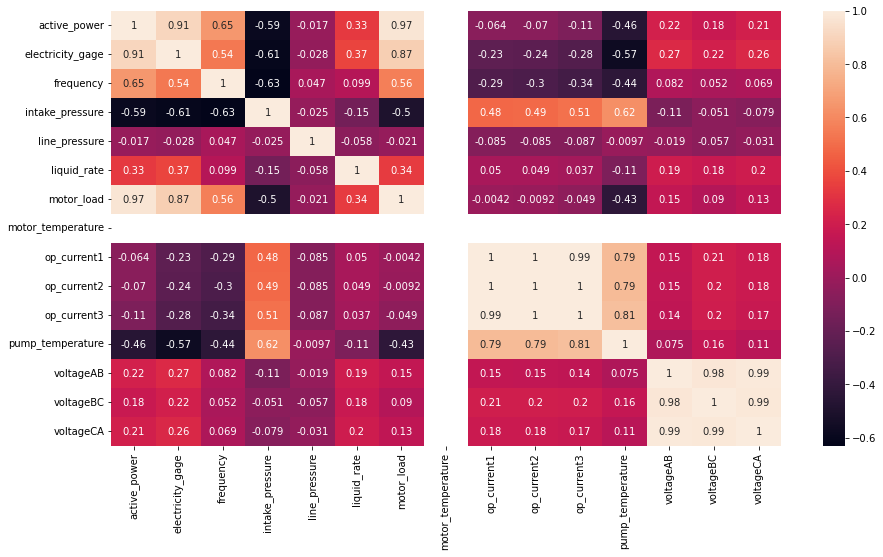

In [14]:
plt.figure(figsize=(15, 8))
sns.heatmap(test_data.drop(["event_id", "well"], axis=1).corr(), annot=True)

From correlation matrix we can conclude that features: motor_load + active_power, motor_load + electicity_gage, currents, voltages are highly correlated. Thus one of the pairs can be removed from datasets

In [15]:
DO_DROPNA = True

In [16]:
if DO_DROPNA:
    for df in wells_data:
        df.dropna(inplace=True)
    
    data_prep.check_nans(wells_data)

In [17]:
wells_data[0]["event_id"].value_counts()

0      283578
759     12420
266     10080
267      3600
7        3360
962      2160
966      1440
268       720
Name: event_id, dtype: int64

In [18]:
# Reduce memory usage

for df in wells_data:
    df = data_prep.reduce_mem_usage(df)

Mem. usage decreased to 28.75 Mb (48.4% reduction)
Mem. usage decreased to 19.78 Mb (48.0% reduction)
Mem. usage decreased to 16.60 Mb (48.3% reduction)
Mem. usage decreased to 16.61 Mb (48.3% reduction)


In [19]:
wells_data[0]["event_id"].value_counts()

0      283578
759     12420
266     10080
267      3600
7        3360
962      2160
966      1440
268       720
Name: event_id, dtype: int64

### Feature Engineering

In [20]:
wells_data[1].columns

Index(['time', 'active_power', 'electricity_gage', 'frequency',
       'intake_pressure', 'line_pressure', 'liquid_rate', 'motor_load',
       'motor_temperature', 'op_current1', 'op_current2', 'op_current3',
       'pump_temperature', 'voltageAB', 'voltageBC', 'voltageCA', 'well',
       'event_id'],
      dtype='object')

In [21]:
common_cols = [wells_data[0].columns]
for df in wells_data:
    cols = df.columns
    common_cols = np.intersect1d(common_cols, cols)
    print(df["well"].values[0])
    print(df.shape)

1
(317358, 22)
4
(262488, 18)
7
(191236, 21)
8
(191443, 21)


In [22]:
common_cols

array(['active_power', 'electricity_gage', 'event_id', 'frequency',
       'intake_pressure', 'line_pressure', 'liquid_rate', 'motor_load',
       'motor_temperature', 'op_current1', 'op_current2', 'op_current3',
       'pump_temperature', 'time', 'voltageAB', 'voltageBC', 'voltageCA',
       'well'], dtype=object)

In [23]:
data_fe = []

for df in wells_data:
    df = df[common_cols]
    temp = data_prep.features_calculation(df)
    data_fe.append(temp)
    print(temp.shape)

(317358, 58)
(262488, 58)
(191236, 58)
(191443, 58)


In [24]:
data_fe[0].shape[0] + data_fe[1].shape[0] + data_fe[2].shape[0] + data_fe[3].shape[0]

962525

In [25]:
wells_data[0]["event_id"].value_counts()

0      283578
759     12420
266     10080
267      3600
7        3360
962      2160
966      1440
268       720
Name: event_id, dtype: int64

In [26]:
# summary2 = get_data_summary2(data_fe[0].drop(["well", "event_id"], axis=1))

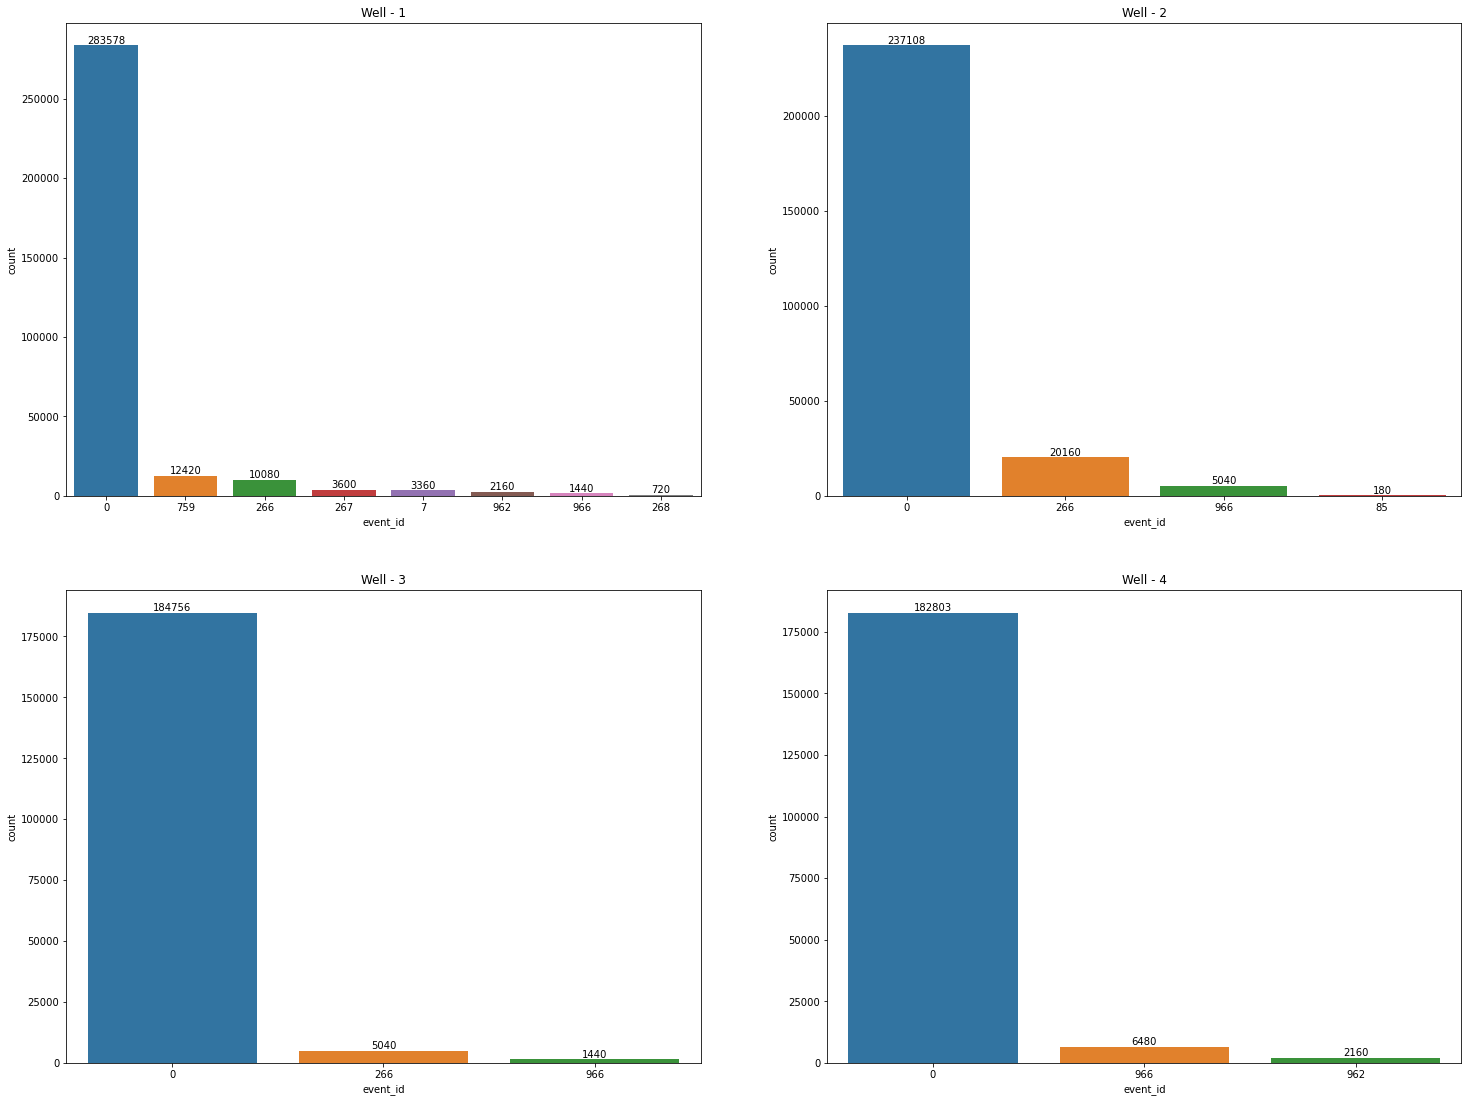

In [27]:
plt.figure(figsize=(25, 40))
for i, df in enumerate(wells_data):
    plt.subplot(len(wells_data), 2, i+1)
    ax = sns.countplot(x=df["event_id"], order=df["event_id"].value_counts(ascending=False).index)
    abs_values = df['event_id'].value_counts(ascending=False).values
    ax.bar_label(container=ax.containers[0], labels=abs_values)
    plt.title(f"Well - {i+1}")

In [28]:
data_expanded = []

for df in data_fe:
    temp = data_prep.expand_target(df, split=True)
    data_expanded.append(temp)

c:\Users\vladv\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


Initial shape : 159840, outliers : 36005


c:\Users\vladv\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


Initial shape : 176400, outliers : 43959
Initial shape : 191236, outliers : 48979
Initial shape : 191443, outliers : 32167


In [29]:
for df in data_expanded:
    print(df.shape)

(123835, 61)
(132441, 61)
(142257, 61)
(159276, 61)


In [30]:
train_df, test_df = data_prep.join_data(data_expanded)

c:\Users\vladv\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


Joined data shape : (557809, 64)


In [31]:
train_df = data_prep.reduce_mem_usage(train_df)
test_df = data_prep.reduce_mem_usage(test_df)

Mem. usage decreased to 120.82 Mb (39.6% reduction)
Mem. usage decreased to 15.36 Mb (39.6% reduction)


In [32]:
test_df.shape[0], train_df.shape[0]

(62924, 494885)

Text(0.5, 0, 'Поломка/нет')

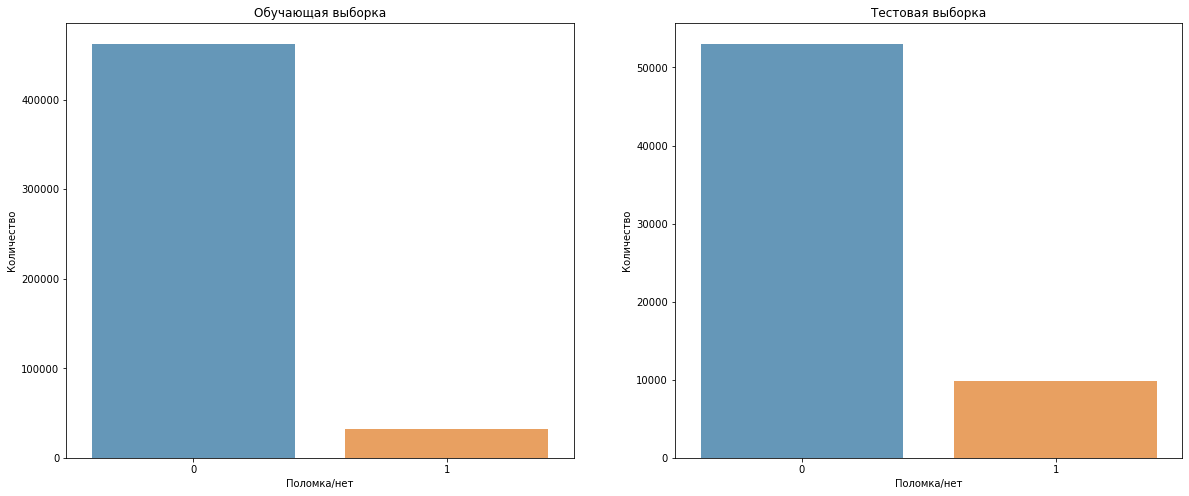

In [33]:
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
sns.countplot(x="failure_target", data=train_df, alpha=0.75)
plt.title("Обучающая выборка")
plt.ylabel("Количество")
plt.xlabel("Поломка/нет")
plt.subplot(1, 2, 2)
sns.countplot(x="failure_target", data=test_df, alpha=0.75)
plt.title("Тестовая выборка")
# plt.legend([1, 2, 3, 4])
plt.ylabel("Количество")
plt.xlabel("Поломка/нет")

In [34]:
# plt.figure(figsize=(10, 8))
# sns.countplot(x="event_id", data=train_df[train_df["event_id"] != 0], hue="well", alpha=0.75)
# plt.legend([1, 2, 3, 4])
# plt.ylabel("Количество")
# plt.xlabel("ID неисправности")

In [35]:
test_df["event_id"].value_counts()

0      56635
966     6242
266       47
Name: event_id, dtype: int64

In [36]:
get_data_summary2(data_fe[1]).to_clipboard()

In [37]:
train_df["failure_target"].sum(), test_df["failure_target"].sum()

(32438, 9872)

In [38]:
train_df["failure_target"].mean(), test_df["failure_target"].mean()

(0.06554654111561271, 0.15688767401945203)

In [40]:
train_df.to_csv("./full_joined_clean_data_3_7_daysTRAIN22.csv")
test_df.to_csv("./full_joined_clean_data_3_7_daysTEST22.csv")

In [49]:
events = data_prep.get_events_summary(PATH)

In [59]:
events[events["startDate"].dt.month == 5][["event", "startDate", "endDate", "level", "losses", "well_id"]]

,event,startDate,endDate,level,losses,well_id
27,Неустановившейся режим,2021-05-11 01:30:09.019,2021-05-18 01:30:09.019,Отказ,0.0,1
28,Неустановившейся режим,2021-05-01 06:32:41.000,2021-05-08 06:32:41.000,Отказ,0.0,1
9,Неустановившейся режим,2021-05-26 11:31:19.618,2021-06-02 11:31:19.618,Отказ,0.0,4
10,Неустановившейся режим,2021-05-19 11:30:20.928,2021-05-26 11:30:20.928,Отказ,0.0,4
15,Неустановившейся режим,2021-05-12 11:00:39.334,2021-05-19 11:00:39.334,Отказ,0.0,4
16,Неустановившейся режим,2021-05-01 06:32:41.000,2021-05-08 06:32:41.000,Отказ,0.0,4
4,Неустановившейся режим,2021-05-15 13:30:16.421,2021-05-22 13:30:16.421,Отказ,0.0,7


In [55]:
events.columns

Index(['id', 'ruleName', 'event', 'result', 'parameters', 'startDate',
       'endDate', 'status', 'level', 'activity', 'losses', 'fail',
       'eventsType', 'eventsState', 'timeStamp', 'timeToLive', 'reject',
       'comment', 'loginName', 'well_id', 'fact', 'weight'],
      dtype='object')